In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import pyarrow.feather as feather
import sklearn.preprocessing as skl_preprocessing
from sklearn.metrics import r2_score
import tensorflow.keras.layers.experimental.preprocessing as tf_preprocessing
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping

In [2]:
from datetime import datetime
from keras.callbacks import TensorBoard

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5412920141592417700
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22729785344
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6204916353531170771
 physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [5]:
input_root_path = "P:\SALMALIS Lab\Work Zone Dataset"
output_root_path = "./"

# Load Dataset

In [6]:
df = feather.read_feather(os.path.join(input_root_path, 'TravelTime_Valid_Recom_Weather_Traffic.ftr'))
# df = pd.read_csv(os.path.join(input_root_path, 'TravelTime_Valid_Recom_Weather_Traffic.csv'))
df

,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,Weather:Lat,Weather:Temp,Weather:Precip,Weather:WindSpd,Traffic:SiteNo,Traffic:IsTemporary,Traffic:AADT,Traffic:BaseYear,Traffic:CalculatedAADT,MaxSpeed
0,49831911074,Spread 3B,2022-05-03 17:59:55,2.20,2.13,0.07,OK,3.36,SB,Spread 3B,...,52.72,NaN,NaN,NaN,23-010NS,True,355.333333,2017.0,373.10,100.0
1,49831911074,Spread 3B,2022-05-03 17:57:32,2.20,2.13,0.07,OK,3.36,SB,Spread 3B,...,52.72,NaN,NaN,NaN,23-010NS,True,355.333333,2017.0,373.10,100.0
2,49831911074,Spread 3B,2022-05-03 17:55:23,2.20,2.13,0.07,OK,3.36,SB,Spread 3B,...,52.72,NaN,NaN,NaN,23-010NS,True,355.333333,2017.0,373.10,100.0
3,49831911074,Spread 3B,2022-05-03 17:53:29,2.20,2.13,0.07,OK,3.36,SB,Spread 3B,...,52.72,NaN,NaN,NaN,23-010NS,True,355.333333,2017.0,373.10,100.0
4,49831911074,Spread 3B,2022-05-03 17:51:45,2.23,2.13,0.10,OK,3.36,SB,Spread 3B,...,52.72,NaN,NaN,NaN,23-010NS,True,355.333333,2017.0,373.10,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816070,86704972236,AP 6-A-66-A • NB • Macro Spiecapag JV • 1073.6,2021-05-01 18:40:12,1.38,1.48,0.00,OK,2.45,NB,Spread 5B,...,49.24,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,NaN
2816071,86704972236,AP 6-A-66-A • NB • Macro Spiecapag JV • 1073.6,2021-05-01 18:45:11,1.38,1.48,0.00,OK,2.45,NB,Spread 5B,...,49.24,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,NaN
2816072,86704972236,AP 6-A-66-A • NB • Macro Spiecapag JV • 1073.6,2021-05-01 18:50:10,1.38,1.48,0.00,OK,2.45,NB,Spread 5B,...,49.24,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,NaN
2816073,86704972236,AP 6-A-66-A • NB • Macro Spiecapag JV • 1073.6,2021-05-01 18:51:07,1.37,1.48,0.00,OK,2.45,NB,Spread 5B,...,49.24,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,NaN


In [7]:
# Get No Cell Coverage Area Assets
assets_no_cell = pd.read_csv(os.path.join(input_root_path, 'NoCellAssets.csv'))['Asset Number'].tolist()

# Prepare data to feed the network

In [8]:
df_processed = df.dropna(axis=0).copy()

df_processed['CreatedDate:Season_Code'] = df_processed['CreatedDate:Month']%12 // 3 + 1
df_processed = df_processed[(df_processed['UnderConstructionTime'] < 7) & (df_processed['BaselineTime'] < 10)].reset_index(drop=True)
df_processed

,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,Weather:Temp,Weather:Precip,Weather:WindSpd,Traffic:SiteNo,Traffic:IsTemporary,Traffic:AADT,Traffic:BaseYear,Traffic:CalculatedAADT,MaxSpeed,CreatedDate:Season_Code
0,19078590783,Spread 4B,2022-03-31 18:04:10,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,7.2,0.0,4.0,21-013EW,True,55.428571,2017.0,58.2,100.0,2
1,19078590783,Spread 4B,2022-03-31 18:01:48,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,7.2,0.0,4.0,21-013EW,True,55.428571,2017.0,58.2,100.0,2
2,19078590783,Spread 4B,2022-03-31 17:59:46,1.65,1.63,0.02,OK,2.70,NB,Spread 4B,...,9.2,0.0,10.0,21-013EW,True,68.571429,2017.0,72.0,100.0,2
3,19078590783,Spread 4B,2022-03-31 17:58:02,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,9.2,0.0,10.0,21-013EW,True,68.571429,2017.0,72.0,100.0,2
4,19078590783,Spread 4B,2022-03-31 17:56:10,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,9.2,0.0,10.0,21-013EW,True,68.571429,2017.0,72.0,100.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715222,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:10:15,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,5.3,0.0,5.0,23-010NS,True,35.000000,2017.0,36.4,100.0,2
715223,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:15:14,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,5.3,0.0,5.0,23-010NS,True,35.000000,2017.0,36.4,100.0,2
715224,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:20:17,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,5.3,0.0,5.0,23-010NS,True,35.000000,2017.0,36.4,100.0,2
715225,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:25:14,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,5.3,0.0,5.0,23-010NS,True,35.000000,2017.0,36.4,100.0,2


In [9]:
df_processed.isnull().sum()

AssetNumber                0
AssetIdentifier            0
CreatedDate                0
UnderConstructionTime      0
BaselineTime               0
DelayTime                  0
State                      0
SegmentLength              0
TravelDirect               0
Spread                     0
TrafficImpact              0
RoadType                   0
TrafficControlSetup        0
CreatedDate:Date           0
CreatedDate:Weekday        0
CreatedDate:DayOfYear      0
CreatedDate:Year           0
CreatedDate:Month          0
CreatedDate:Day            0
CreatedDate:Hour           0
CreatedDate:MinuteInDay    0
CreatedDate:Season         0
Weather:StationID          0
Weather:Long               0
Weather:Lat                0
Weather:Temp               0
Weather:Precip             0
Weather:WindSpd            0
Traffic:SiteNo             0
Traffic:IsTemporary        0
Traffic:AADT               0
Traffic:BaseYear           0
Traffic:CalculatedAADT     0
MaxSpeed                   0
CreatedDate:Se

In [61]:
n_unique = df_processed.nunique()

df_processed.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()
# df_processed.columns

,count,mean,std,min,25%,50%,75%,max
AssetNumber,715227.00000,43869615300.36515,25429304755.59473,11840206827.00000,24425064561.00000,33018599622.00000,64413418329.00000,98128214373.00000
UnderConstructionTime,715227.00000,1.73298,0.46209,1.00000,1.42000,1.65000,1.93000,6.58000
BaselineTime,715227.00000,1.66665,0.37083,1.00000,1.38000,1.65000,1.87000,2.92000
DelayTime,715227.00000,0.11596,0.24715,0.00000,0.00000,0.00000,0.07000,5.33000
SegmentLength,715227.00000,2.79013,0.56162,2.14000,2.43000,2.74000,3.05800,4.59000
...,...,...,...,...,...,...,...,...
Weather:Temp_norm,715227.00000,-0.00000,1.00002,-3.45726,-0.52649,0.10153,0.63983,3.31640
Weather:Precip_norm,715227.00000,-0.00000,1.00000,-0.23178,-0.23178,-0.23178,-0.23178,18.68844
Weather:WindSpd_norm,715227.00000,0.00001,1.00002,-1.40770,-0.78440,-0.16110,0.46221,6.90301
Traffic:CalculatedAADT_norm,715227.00000,0.00000,1.00003,-1.04707,-0.85401,-0.33205,0.67785,4.61352


In [60]:
n_unique

AssetNumber                        59
AssetIdentifier                    45
CreatedDate                    274011
UnderConstructionTime             237
BaselineTime                       43
                                ...  
Weather:Temp_norm                 376
Weather:Precip_norm                43
Weather:WindSpd_norm               36
Traffic:CalculatedAADT_norm       197
MaxSpeed_norm                       3
Length: 79, dtype: int64

## Cyclical features encoding

In [11]:
cyclical_cols = ["CreatedDate:Season_Code", "CreatedDate:Month", "CreatedDate:Day", "CreatedDate:DayOfYear", "CreatedDate:Weekday", "CreatedDate:Hour", "CreatedDate:MinuteInDay"]
for col in cyclical_cols:
    scaler = skl_preprocessing.MinMaxScaler(feature_range=(-1, 1))
    df_processed[col + "_norm"] = scaler.fit_transform(df_processed[col].to_numpy().reshape(-1, 1)) * np.pi
    df_processed[col + "_sin"] = np.sin(df_processed[col])
    df_processed[col + "_cos"] = np.cos(df_processed[col])

df_processed

,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,CreatedDate:DayOfYear_cos,CreatedDate:Weekday_norm,CreatedDate:Weekday_sin,CreatedDate:Weekday_cos,CreatedDate:Hour_norm,CreatedDate:Hour_sin,CreatedDate:Hour_cos,CreatedDate:MinuteInDay_norm,CreatedDate:MinuteInDay_sin,CreatedDate:MinuteInDay_cos
0,19078590783,Spread 4B,2022-03-31 18:04:10,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,-0.448074,0.000000,0.141120,-0.989992,1.775683,-0.750987,0.660317,1.591537,-0.149967,-0.988691
1,19078590783,Spread 4B,2022-03-31 18:01:48,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,-0.448074,0.000000,0.141120,-0.989992,1.775683,-0.750987,0.660317,1.578437,0.287990,0.957633
2,19078590783,Spread 4B,2022-03-31 17:59:46,1.65,1.63,0.02,OK,2.70,NB,Spread 4B,...,-0.448074,0.000000,0.141120,-0.989992,1.502501,-0.961397,-0.275163,1.569705,-0.990620,-0.136648
3,19078590783,Spread 4B,2022-03-31 17:58:02,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,-0.448074,0.000000,0.141120,-0.989992,1.502501,-0.961397,-0.275163,1.565338,-0.420249,-0.907409
4,19078590783,Spread 4B,2022-03-31 17:56:10,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,-0.448074,0.000000,0.141120,-0.989992,1.502501,-0.961397,-0.275163,1.556606,0.999990,-0.004516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715222,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:10:15,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.941026,1.047198,-0.756802,-0.653644,-2.595229,0.909297,-0.416147,-2.573966,-0.930106,-0.367291
715223,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:15:14,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.941026,1.047198,-0.756802,-0.653644,-2.595229,0.909297,-0.416147,-2.552135,0.088369,-0.996088
715224,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:20:17,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.941026,1.047198,-0.756802,-0.653644,-2.595229,0.909297,-0.416147,-2.530303,0.980240,-0.197814
715225,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:25:14,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.941026,1.047198,-0.756802,-0.653644,-2.595229,0.909297,-0.416147,-2.508471,0.467745,0.883863


## One-hot encoding

In [12]:
onehot_cols = ['TravelDirect', 'Spread', 'TrafficImpact', 'RoadType', 'TrafficControlSetup']
for col in onehot_cols:
    label_encoder = skl_preprocessing.LabelEncoder()

    integer_encoded = label_encoder.fit_transform(df_processed[col])
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

    onehot_encoder = skl_preprocessing.OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_df = pd.DataFrame(onehot_encoded, columns=[col + ':' + category.replace(" ", "") + "_onehot" for category in df_processed[col].unique()])
    df_processed = df_processed.join(onehot_df)

df_processed

,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,Spread:Reactivation_onehot,Spread:Spread5B_onehot,TrafficImpact:Low_onehot,TrafficImpact:Moderate_onehot,TrafficImpact:High_onehot,"RoadType:Two-Lane,Two-WayRoadways(>70km/h)_onehot",RoadType:Multi-LaneDivided_onehot,TrafficControlSetup:SLAT_onehot,TrafficControlSetup:BriefDuration_onehot,TrafficControlSetup:LaneClosure_onehot
0,19078590783,Spread 4B,2022-03-31 18:04:10,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,19078590783,Spread 4B,2022-03-31 18:01:48,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,19078590783,Spread 4B,2022-03-31 17:59:46,1.65,1.63,0.02,OK,2.70,NB,Spread 4B,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,19078590783,Spread 4B,2022-03-31 17:58:02,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,19078590783,Spread 4B,2022-03-31 17:56:10,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715222,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:10:15,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
715223,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:15:14,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
715224,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:20:17,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
715225,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:25:14,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


## Normalize

In [13]:
%%time

norm_cols = ['UnderConstructionTime', 'BaselineTime', 'DelayTime', 'SegmentLength', 'CreatedDate:Year', 'Weather:Temp', 'Weather:Precip', 'Weather:WindSpd', 'Traffic:CalculatedAADT', 'MaxSpeed']
for col in norm_cols:
    print(col, "DONE!")
    norm_layer = tf_preprocessing.Normalization()
    norm_layer.adapt(df_processed[col])
    df_processed[col + "_norm"] = norm_layer(df_processed[col]).numpy().reshape(-1)

df_processed

UnderConstructionTime DONE!
BaselineTime DONE!
DelayTime DONE!
SegmentLength DONE!
CreatedDate:Year DONE!
Weather:Temp DONE!
Weather:Precip DONE!
Weather:WindSpd DONE!
Traffic:CalculatedAADT DONE!
MaxSpeed DONE!
CPU times: total: 5min 12s
Wall time: 3min 30s


,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,UnderConstructionTime_norm,BaselineTime_norm,DelayTime_norm,SegmentLength_norm,CreatedDate:Year_norm,Weather:Temp_norm,Weather:Precip_norm,Weather:WindSpd_norm,Traffic:CalculatedAADT_norm,MaxSpeed_norm
0,19078590783,Spread 4B,2022-03-31 18:04:10,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,-0.287798,-0.098878,-0.469180,-0.160496,0.783425,-0.077907,-0.231776,-0.576632,-0.773363,-0.328568
1,19078590783,Spread 4B,2022-03-31 18:01:48,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,-0.287798,-0.098878,-0.469180,-0.160496,0.783425,-0.077907,-0.231776,-0.576632,-0.773363,-0.328568
2,19078590783,Spread 4B,2022-03-31 17:59:46,1.65,1.63,0.02,OK,2.70,NB,Spread 4B,...,-0.179592,-0.098878,-0.388258,-0.160496,0.783425,0.221151,-0.231776,0.669974,-0.697859,-0.328568
3,19078590783,Spread 4B,2022-03-31 17:58:02,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,-0.287798,-0.098878,-0.469180,-0.160496,0.783425,0.221151,-0.231776,0.669974,-0.697859,-0.328568
4,19078590783,Spread 4B,2022-03-31 17:56:10,1.60,1.63,0.00,OK,2.70,NB,Spread 4B,...,-0.287798,-0.098878,-0.469180,-0.160496,0.783425,0.221151,-0.231776,0.669974,-0.697859,-0.328568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715222,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:10:15,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.504211,-0.395516,-0.469180,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568
715223,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:15:14,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.504211,-0.395516,-0.469180,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568
715224,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:20:17,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.504211,-0.395516,-0.469180,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568
715225,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:25:14,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.504211,-0.395516,-0.469180,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568


## EDA

### General

In [14]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715227 entries, 0 to 715226
Data columns (total 79 columns):
 #   Column                                             Non-Null Count   Dtype         
---  ------                                             --------------   -----         
 0   AssetNumber                                        715227 non-null  int64         
 1   AssetIdentifier                                    715227 non-null  object        
 2   CreatedDate                                        715227 non-null  datetime64[ns]
 3   UnderConstructionTime                              715227 non-null  float64       
 4   BaselineTime                                       715227 non-null  float64       
 5   DelayTime                                          715227 non-null  float64       
 6   State                                              715227 non-null  object        
 7   SegmentLength                                      715227 non-null  float64       
 8   Trav

In [15]:
df_processed.isnull().sum()

AssetNumber                    0
AssetIdentifier                0
CreatedDate                    0
UnderConstructionTime          0
BaselineTime                   0
                              ..
Weather:Temp_norm              0
Weather:Precip_norm            0
Weather:WindSpd_norm           0
Traffic:CalculatedAADT_norm    0
MaxSpeed_norm                  0
Length: 79, dtype: int64

In [16]:
df_processed.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()

,count,mean,std,min,25%,50%,75%,max
AssetNumber,715227.00000,43869615300.36515,25429304755.59473,11840206827.00000,24425064561.00000,33018599622.00000,64413418329.00000,98128214373.00000
UnderConstructionTime,715227.00000,1.73298,0.46209,1.00000,1.42000,1.65000,1.93000,6.58000
BaselineTime,715227.00000,1.66665,0.37083,1.00000,1.38000,1.65000,1.87000,2.92000
DelayTime,715227.00000,0.11596,0.24715,0.00000,0.00000,0.00000,0.07000,5.33000
SegmentLength,715227.00000,2.79013,0.56162,2.14000,2.43000,2.74000,3.05800,4.59000
...,...,...,...,...,...,...,...,...
Weather:Temp_norm,715227.00000,-0.00000,1.00002,-3.45726,-0.52649,0.10153,0.63983,3.31640
Weather:Precip_norm,715227.00000,-0.00000,1.00000,-0.23178,-0.23178,-0.23178,-0.23178,18.68844
Weather:WindSpd_norm,715227.00000,0.00001,1.00002,-1.40770,-0.78440,-0.16110,0.46221,6.90301
Traffic:CalculatedAADT_norm,715227.00000,0.00000,1.00003,-1.04707,-0.85401,-0.33205,0.67785,4.61352


In [17]:
df_processed.describe(include='object').transpose()

,count,unique,top,freq
AssetIdentifier,715227,45,Spread 5B,347417
State,715227,2,OK,715211
TravelDirect,715227,2,SB,383875
Spread,715227,3,Spread 5B,406244
TrafficImpact,715227,3,High,428245
RoadType,715227,2,Multi-Lane Divided,406244
TrafficControlSetup,715227,3,Lane Closure,406244
CreatedDate:Date,715227,165,2021-03-13,24899
CreatedDate:Season,715227,2,Spring,629326
Traffic:SiteNo,715227,7,23-010NS,296879


### Histogram

In [18]:
# sns.pairplot(df_processed[['UnderConstructionTime', 'BaselineTime', 'DelayTime']])
# plt.show()

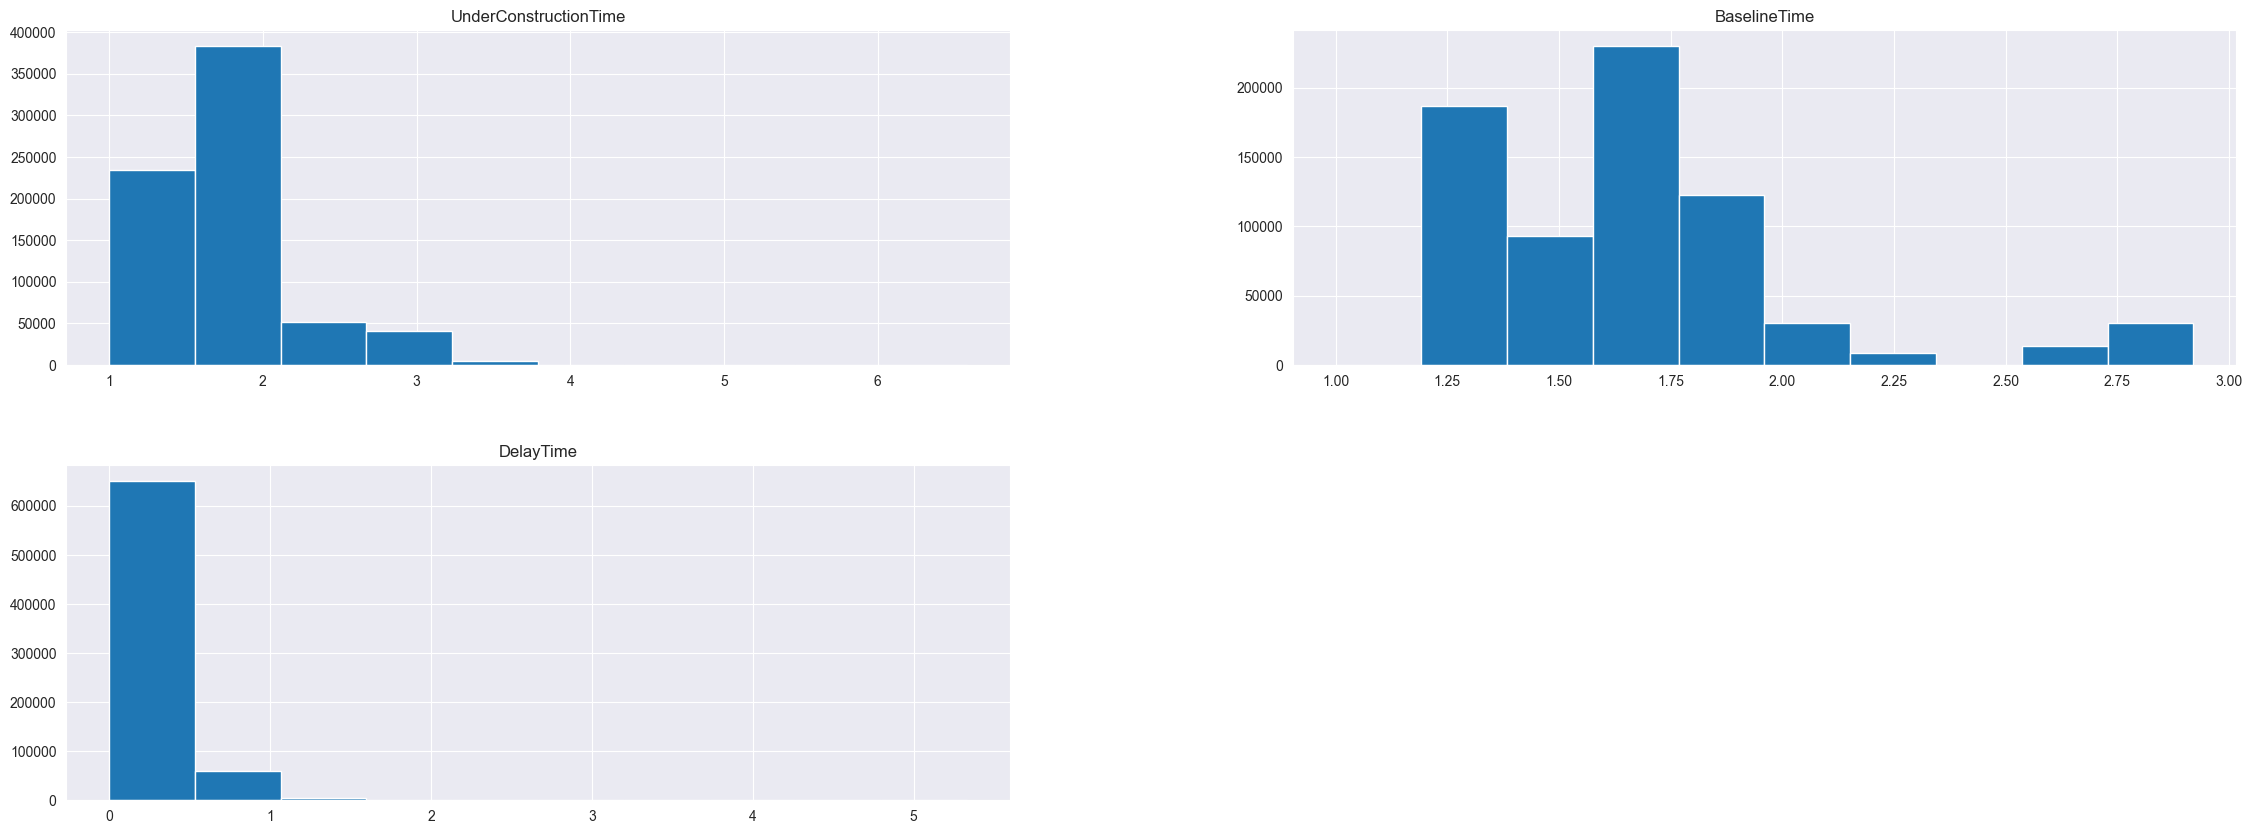

In [19]:
df_processed[['UnderConstructionTime', 'BaselineTime', 'DelayTime']].hist(figsize = (28,10))
# count, division = np.histogram(df_processed['UnderConstructionTime'])
# print(count)
# print(division)
plt.show()

### Correlation Matrix

C:\Users\SALMALIS 2\AppData\Local\Temp\ipykernel_6776\3273951945.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  C_mat = df_processed.corr()


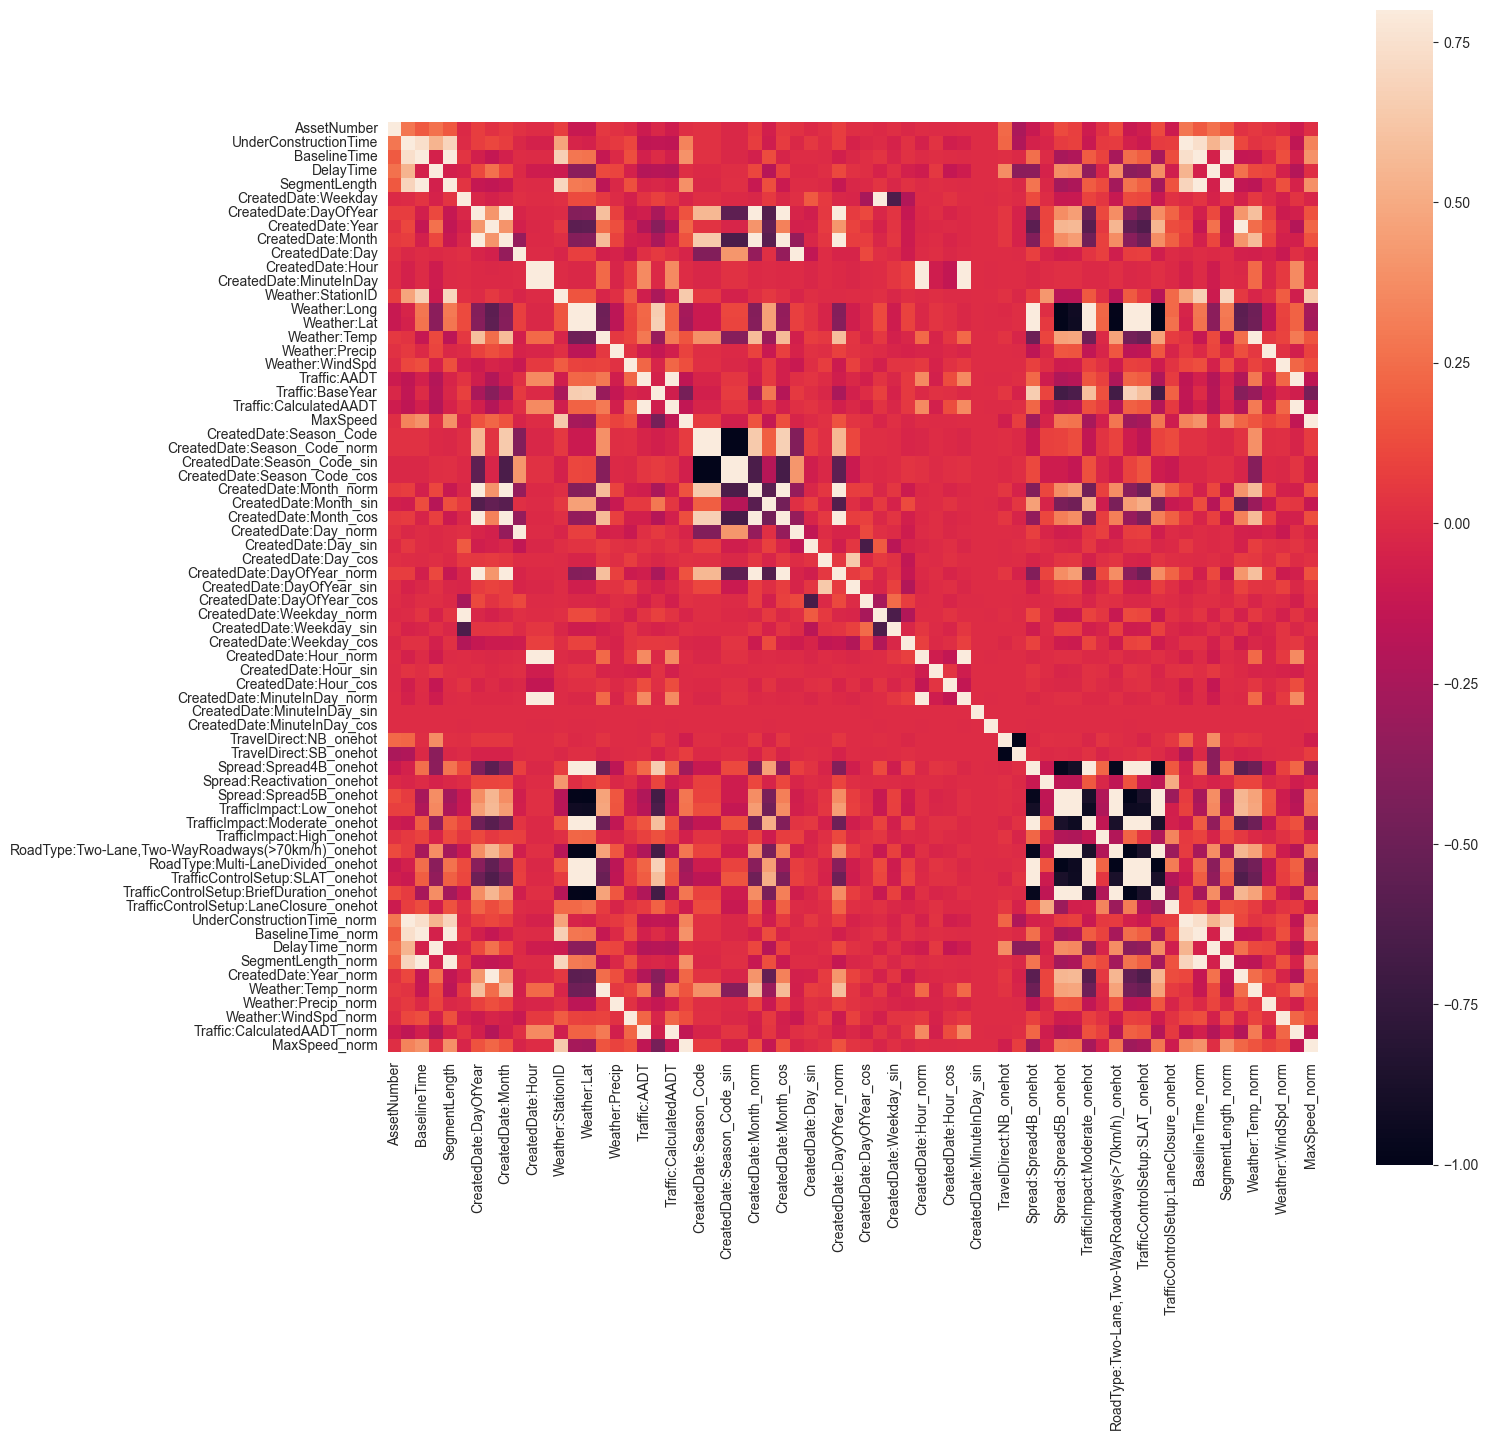

In [20]:
C_mat = df_processed.corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, vmax = .8, square = True)
plt.show()

## Divide into training and test set

### Training Set

In [21]:
df_train = df_processed[~df_processed['AssetNumber'].isin(assets_no_cell)]
df_train

,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,UnderConstructionTime_norm,BaselineTime_norm,DelayTime_norm,SegmentLength_norm,CreatedDate:Year_norm,Weather:Temp_norm,Weather:Precip_norm,Weather:WindSpd_norm,Traffic:CalculatedAADT_norm,MaxSpeed_norm
0,19078590783,Spread 4B,2022-03-31 18:04:10,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.287798,-0.098878,-0.469180,-0.160496,0.783425,-0.077907,-0.231776,-0.576632,-0.773363,-0.328568
1,19078590783,Spread 4B,2022-03-31 18:01:48,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.287798,-0.098878,-0.469180,-0.160496,0.783425,-0.077907,-0.231776,-0.576632,-0.773363,-0.328568
2,19078590783,Spread 4B,2022-03-31 17:59:46,1.65,1.63,0.02,OK,2.700,NB,Spread 4B,...,-0.179592,-0.098878,-0.388258,-0.160496,0.783425,0.221151,-0.231776,0.669974,-0.697859,-0.328568
3,19078590783,Spread 4B,2022-03-31 17:58:02,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.287798,-0.098878,-0.469180,-0.160496,0.783425,0.221151,-0.231776,0.669974,-0.697859,-0.328568
4,19078590783,Spread 4B,2022-03-31 17:56:10,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.287798,-0.098878,-0.469180,-0.160496,0.783425,0.221151,-0.231776,0.669974,-0.697859,-0.328568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714698,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:40:12,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,-0.677341,-0.719122,-0.388258,-0.619879,-1.272250,0.968794,-0.231776,-0.161097,2.556048,-0.328568
714699,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:45:11,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,-0.677341,-0.719122,-0.388258,-0.619879,-1.272250,0.968794,-0.231776,-0.161097,2.556048,-0.328568
714700,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:50:10,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,-0.677341,-0.719122,-0.388258,-0.619879,-1.272250,0.968794,-0.231776,-0.161097,2.556048,-0.328568
714701,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:51:08,1.43,1.40,0.03,OK,2.442,SB,Spread 5B,...,-0.655700,-0.719122,-0.347798,-0.619879,-1.272250,0.968794,-0.231776,-0.161097,2.556048,-0.328568


In [36]:
df_train.columns


Index(['AssetNumber', 'AssetIdentifier', 'CreatedDate',
       'UnderConstructionTime', 'BaselineTime', 'DelayTime', 'State',
       'SegmentLength', 'TravelDirect', 'Spread', 'TrafficImpact', 'RoadType',
       'TrafficControlSetup', 'CreatedDate:Date', 'CreatedDate:Weekday',
       'CreatedDate:DayOfYear', 'CreatedDate:Year', 'CreatedDate:Month',
       'CreatedDate:Day', 'CreatedDate:Hour', 'CreatedDate:MinuteInDay',
       'CreatedDate:Season', 'Weather:StationID', 'Weather:Long',
       'Weather:Lat', 'Weather:Temp', 'Weather:Precip', 'Weather:WindSpd',
       'Traffic:SiteNo', 'Traffic:IsTemporary', 'Traffic:AADT',
       'Traffic:BaseYear', 'Traffic:CalculatedAADT', 'MaxSpeed',
       'CreatedDate:Season_Code', 'CreatedDate:Season_Code_norm',
       'CreatedDate:Season_Code_sin', 'CreatedDate:Season_Code_cos',
       'CreatedDate:Month_norm', 'CreatedDate:Month_sin',
       'CreatedDate:Month_cos', 'CreatedDate:Day_norm', 'CreatedDate:Day_sin',
       'CreatedDate:Day_cos', 'Cre

In [37]:
x_drop_cols = ['UnderConstructionTime_norm','BaselineTime_norm', 'DelayTime_norm', 'AssetNumber', 'AssetIdentifier', 'CreatedDate', 'UnderConstructionTime', 'BaselineTime', 'DelayTime', 'State', 'SegmentLength', 'TravelDirect', 'Spread', 'TrafficImpact', 'RoadType', 'TrafficControlSetup', 'CreatedDate:Date', 'CreatedDate:Weekday','CreatedDate:DayOfYear', 'CreatedDate:Year', 'CreatedDate:Month', 'CreatedDate:Day', 'CreatedDate:Hour', 'CreatedDate:MinuteInDay', 'CreatedDate:Season', 'Weather:StationID', 'Weather:Long', 'Weather:Lat', 'Weather:Temp', 'Weather:Precip', 'Weather:WindSpd', 'Traffic:SiteNo', 'Traffic:IsTemporary', 'Traffic:AADT', 'Traffic:BaseYear', 'Traffic:CalculatedAADT', 'MaxSpeed', 'CreatedDate:Season_Code_norm', 'CreatedDate:Month_norm', 'CreatedDate:Day_norm', 'CreatedDate:DayOfYear_norm', 'CreatedDate:Weekday_norm', 'CreatedDate:Hour_norm','CreatedDate:MinuteInDay_norm']

In [38]:
x_train = df_train.copy().drop(columns=x_drop_cols)
print(len(x_train.columns))
print(x_train.columns)
x_train

35
Index(['CreatedDate:Season_Code', 'CreatedDate:Season_Code_sin',
       'CreatedDate:Season_Code_cos', 'CreatedDate:Month_sin',
       'CreatedDate:Month_cos', 'CreatedDate:Day_sin', 'CreatedDate:Day_cos',
       'CreatedDate:DayOfYear_sin', 'CreatedDate:DayOfYear_cos',
       'CreatedDate:Weekday_sin', 'CreatedDate:Weekday_cos',
       'CreatedDate:Hour_sin', 'CreatedDate:Hour_cos',
       'CreatedDate:MinuteInDay_sin', 'CreatedDate:MinuteInDay_cos',
       'TravelDirect:NB_onehot', 'TravelDirect:SB_onehot',
       'Spread:Spread4B_onehot', 'Spread:Reactivation_onehot',
       'Spread:Spread5B_onehot', 'TrafficImpact:Low_onehot',
       'TrafficImpact:Moderate_onehot', 'TrafficImpact:High_onehot',
       'RoadType:Two-Lane,Two-WayRoadways(>70km/h)_onehot',
       'RoadType:Multi-LaneDivided_onehot', 'TrafficControlSetup:SLAT_onehot',
       'TrafficControlSetup:BriefDuration_onehot',
       'TrafficControlSetup:LaneClosure_onehot', 'SegmentLength_norm',
       'CreatedDate:Year_nor

,CreatedDate:Season_Code,CreatedDate:Season_Code_sin,CreatedDate:Season_Code_cos,CreatedDate:Month_sin,CreatedDate:Month_cos,CreatedDate:Day_sin,CreatedDate:Day_cos,CreatedDate:DayOfYear_sin,CreatedDate:DayOfYear_cos,CreatedDate:Weekday_sin,...,TrafficControlSetup:SLAT_onehot,TrafficControlSetup:BriefDuration_onehot,TrafficControlSetup:LaneClosure_onehot,SegmentLength_norm,CreatedDate:Year_norm,Weather:Temp_norm,Weather:Precip_norm,Weather:WindSpd_norm,Traffic:CalculatedAADT_norm,MaxSpeed_norm
0,2,0.909297,-0.416147,0.141120,-0.989992,-0.404038,0.914742,0.893997,-0.448074,0.141120,...,0.0,0.0,1.0,-0.160496,0.783425,-0.077907,-0.231776,-0.576632,-0.773363,-0.328568
1,2,0.909297,-0.416147,0.141120,-0.989992,-0.404038,0.914742,0.893997,-0.448074,0.141120,...,0.0,0.0,1.0,-0.160496,0.783425,-0.077907,-0.231776,-0.576632,-0.773363,-0.328568
2,2,0.909297,-0.416147,0.141120,-0.989992,-0.404038,0.914742,0.893997,-0.448074,0.141120,...,0.0,0.0,1.0,-0.160496,0.783425,0.221151,-0.231776,0.669974,-0.697859,-0.328568
3,2,0.909297,-0.416147,0.141120,-0.989992,-0.404038,0.914742,0.893997,-0.448074,0.141120,...,0.0,0.0,1.0,-0.160496,0.783425,0.221151,-0.231776,0.669974,-0.697859,-0.328568
4,2,0.909297,-0.416147,0.141120,-0.989992,-0.404038,0.914742,0.893997,-0.448074,0.141120,...,0.0,0.0,1.0,-0.160496,0.783425,0.221151,-0.231776,0.669974,-0.697859,-0.328568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714698,2,0.909297,-0.416147,-0.958924,0.283662,0.841471,0.540302,0.998815,-0.048664,-0.958924,...,0.0,1.0,0.0,-0.619879,-1.272250,0.968794,-0.231776,-0.161097,2.556048,-0.328568
714699,2,0.909297,-0.416147,-0.958924,0.283662,0.841471,0.540302,0.998815,-0.048664,-0.958924,...,0.0,1.0,0.0,-0.619879,-1.272250,0.968794,-0.231776,-0.161097,2.556048,-0.328568
714700,2,0.909297,-0.416147,-0.958924,0.283662,0.841471,0.540302,0.998815,-0.048664,-0.958924,...,0.0,1.0,0.0,-0.619879,-1.272250,0.968794,-0.231776,-0.161097,2.556048,-0.328568
714701,2,0.909297,-0.416147,-0.958924,0.283662,0.841471,0.540302,0.998815,-0.048664,-0.958924,...,0.0,1.0,0.0,-0.619879,-1.272250,0.968794,-0.231776,-0.161097,2.556048,-0.328568


In [39]:
y_train = df_train['DelayTime_norm']
y_train

0        -0.469180
1        -0.469180
2        -0.388258
3        -0.469180
4        -0.469180
            ...   
714698   -0.388258
714699   -0.388258
714700   -0.388258
714701   -0.347798
714702   -0.347798
Name: DelayTime_norm, Length: 430518, dtype: float32

### Test Set

In [40]:
df_test = df_processed[df_processed['AssetNumber'].isin(assets_no_cell)]
df_test

,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,UnderConstructionTime_norm,BaselineTime_norm,DelayTime_norm,SegmentLength_norm,CreatedDate:Year_norm,Weather:Temp_norm,Weather:Precip_norm,Weather:WindSpd_norm,Traffic:CalculatedAADT_norm,MaxSpeed_norm
12104,63867859347,Reactivation,2022-04-22 15:59:18,1.62,1.57,0.05,OK,2.58,NB,Reactivation,...,-0.244515,-0.260680,-0.266876,-0.374163,0.783425,0.580020,-0.231776,0.254439,1.376595,-0.328568
12105,63867859347,Reactivation,2022-04-22 15:57:16,1.62,1.57,0.05,OK,2.58,NB,Reactivation,...,-0.244515,-0.260680,-0.266876,-0.374163,0.783425,0.580020,-0.231776,0.254439,1.376595,-0.328568
12106,63867859347,Reactivation,2022-04-22 15:55:21,1.62,1.57,0.05,OK,2.58,NB,Reactivation,...,-0.244515,-0.260680,-0.266876,-0.374163,0.783425,0.580020,-0.231776,0.254439,1.376595,-0.328568
12107,63867859347,Reactivation,2022-04-22 15:53:19,1.62,1.57,0.05,OK,2.58,NB,Reactivation,...,-0.244515,-0.260680,-0.266876,-0.374163,0.783425,0.580020,-0.231776,0.254439,1.376595,-0.328568
12108,63867859347,Reactivation,2022-04-22 15:51:16,1.62,1.57,0.05,OK,2.58,NB,Reactivation,...,-0.244515,-0.260680,-0.266876,-0.374163,0.783425,0.580020,-0.231776,0.254439,1.376595,-0.328568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715222,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:10:15,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.504211,-0.395516,-0.469180,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568
715223,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:15:14,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.504211,-0.395516,-0.469180,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568
715224,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:20:17,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.504211,-0.395516,-0.469180,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568
715225,93967088503,MRPP-AP 11-A • NB • Ledcor Sicim LP • 418.75,2021-05-28 02:25:14,1.50,1.52,0.00,OK,2.56,NB,Reactivation,...,-0.504211,-0.395516,-0.469180,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568


In [41]:
x_test = df_test.copy().drop(columns=x_drop_cols)
print(len(x_test.columns))
# print(x_test.columns)
x_test

35


,CreatedDate:Season_Code,CreatedDate:Season_Code_sin,CreatedDate:Season_Code_cos,CreatedDate:Month_sin,CreatedDate:Month_cos,CreatedDate:Day_sin,CreatedDate:Day_cos,CreatedDate:DayOfYear_sin,CreatedDate:DayOfYear_cos,CreatedDate:Weekday_sin,...,TrafficControlSetup:SLAT_onehot,TrafficControlSetup:BriefDuration_onehot,TrafficControlSetup:LaneClosure_onehot,SegmentLength_norm,CreatedDate:Year_norm,Weather:Temp_norm,Weather:Precip_norm,Weather:WindSpd_norm,Traffic:CalculatedAADT_norm,MaxSpeed_norm
12104,2,0.909297,-0.416147,-0.756802,-0.653644,-0.008851,-0.999961,-0.889996,0.455969,-0.756802,...,1.0,0.0,0.0,-0.374163,0.783425,0.580020,-0.231776,0.254439,1.376595,-0.328568
12105,2,0.909297,-0.416147,-0.756802,-0.653644,-0.008851,-0.999961,-0.889996,0.455969,-0.756802,...,1.0,0.0,0.0,-0.374163,0.783425,0.580020,-0.231776,0.254439,1.376595,-0.328568
12106,2,0.909297,-0.416147,-0.756802,-0.653644,-0.008851,-0.999961,-0.889996,0.455969,-0.756802,...,1.0,0.0,0.0,-0.374163,0.783425,0.580020,-0.231776,0.254439,1.376595,-0.328568
12107,2,0.909297,-0.416147,-0.756802,-0.653644,-0.008851,-0.999961,-0.889996,0.455969,-0.756802,...,1.0,0.0,0.0,-0.374163,0.783425,0.580020,-0.231776,0.254439,1.376595,-0.328568
12108,2,0.909297,-0.416147,-0.756802,-0.653644,-0.008851,-0.999961,-0.889996,0.455969,-0.756802,...,1.0,0.0,0.0,-0.374163,0.783425,0.580020,-0.231776,0.254439,1.376595,-0.328568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715222,2,0.909297,-0.416147,-0.958924,0.283662,0.270906,-0.962606,-0.338333,-0.941026,-0.756802,...,1.0,0.0,0.0,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568
715223,2,0.909297,-0.416147,-0.958924,0.283662,0.270906,-0.962606,-0.338333,-0.941026,-0.756802,...,1.0,0.0,0.0,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568
715224,2,0.909297,-0.416147,-0.958924,0.283662,0.270906,-0.962606,-0.338333,-0.941026,-0.756802,...,1.0,0.0,0.0,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568
715225,2,0.909297,-0.416147,-0.958924,0.283662,0.270906,-0.962606,-0.338333,-0.941026,-0.756802,...,1.0,0.0,0.0,-0.409774,-1.272250,-0.362011,-0.231776,-0.368865,-0.892638,-0.328568


In [42]:
y_test = df_test['DelayTime_norm']
y_test

12104    -0.266876
12105    -0.266876
12106    -0.266876
12107    -0.266876
12108    -0.266876
            ...   
715222   -0.469180
715223   -0.469180
715224   -0.469180
715225   -0.469180
715226   -0.469180
Name: DelayTime_norm, Length: 284709, dtype: float32

# Model

In [43]:
model = Sequential()

model.add(Dense(units=128, input_dim=x_train.shape[1], activation='relu'))

model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
    
# Output layer
model.add(Dense(units=1, activation='tanh'))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               4608      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 235,009
Trainable params: 235,009
Non-trainable params: 0
_________________________________________________________________


## Fit

In [44]:
# Define the Keras TensorBoard callback.
logdir = "logs/" + datetime.now().strftime("%H_%M-%d")
tensorboard_callback = TensorBoard(log_dir=logdir)
# tensorboard_callback = TensorBoard(log_dir=logdir,
#                                    histogram_freq=1,
#                                    write_graph=True,
#                                    write_images=True,
#                                    update_freq='epoch',
#                                    profile_batch=2,
#                                    embeddings_freq=1)

In [49]:
earlystopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [50]:
set_aside = 1000

In [51]:
# model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test), callbacks=[tensorboard_callback, earlystopping_callback], verbose=1)
model.fit(x_train[:-set_aside], y_train[:-set_aside], epochs=500, batch_size=64, validation_data=(x_train[-set_aside:], y_train[-set_aside:]), callbacks=[tensorboard_callback, earlystopping_callback], verbose=1)


C:\Users\SALMALIS 2\AppData\Local\Temp\ipykernel_6776\1237230619.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model.fit(x_train[:-set_aside], y_train[:-set_aside], epochs=500, batch_size=64, validation_data=(x_train[-set_aside:], y_train[-set_aside:]), callbacks=[tensorboard_callback, earlystopping_callback], verbose=1)


Epoch 1/500
6712/6712 [==============================] - 12s 2ms/step - loss: 0.7086 - val_loss: 0.0079
Epoch 2/500
6712/6712 [==============================] - 12s 2ms/step - loss: 0.6897 - val_loss: 0.0070
Epoch 3/500
6712/6712 [==============================] - 12s 2ms/step - loss: 0.6785 - val_loss: 0.0070
Epoch 4/500
6712/6712 [==============================] - 13s 2ms/step - loss: 0.6724 - val_loss: 0.0061
Epoch 5/500
6712/6712 [==============================] - 13s 2ms/step - loss: 0.6694 - val_loss: 0.0045
Epoch 6/500
6712/6712 [==============================] - 12s 2ms/step - loss: 0.6685 - val_loss: 0.0115
Epoch 7/500
6712/6712 [==============================] - 12s 2ms/step - loss: 0.6655 - val_loss: 0.0052
Epoch 8/500
6712/6712 [==============================] - 12s 2ms/step - loss: 0.6642 - val_loss: 0.0048
Epoch 9/500
6712/6712 [==============================] - 12s 2ms/step - loss: 0.6627 - val_loss: 0.0066
Epoch 10/500
6712/6712 [==============================] - 12s 2m

In [52]:
# %tensorboard --logdir logs

## Evaluate Model

In [57]:
y_pred = model.predict(x_train[-set_aside:])
r2_score(y_train[-set_aside:], y_pred)

C:\Users\SALMALIS 2\AppData\Local\Temp\ipykernel_6776\2508549889.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  r2_score(y_train[-set_aside:], y_pred)


0.12269183881031676

In [58]:
y_pred = model.predict(x_test)
r2_score(y_test, y_pred)

-12.67603606882233

## Save

In [ ]:
model.save("trained/model")

In [ ]:
model.save_weights('trained/model_weights')